### Project 1 SF Crime Data Exploration

### Overview

With the data derived from SFPD Crime Incident reportsing system, The project is to explore the dataset using Spark SQL to mainly answer the three questions:

- Question 1: Count the number of the crimes for different categories.
- Question 2: Count the number of the crimes for different districts.
- Question 3: Count the number of the crimes each Sunday at SF downtown.

### Data Source

https://data.sfgov.org/Public-Safety/Police-Department-Incidents/tmnf-yvry

The dataset includes incidents derived from SFPD Crime Incident Reporting system Updated daily, showing data from 1/1/2003 up until two weeks ago from current date (2/11/2018). Please note: San Francisco police have implemented a new system for tracking crime. The dataset included here is still coming from the old system, which is in the process of being retired (a multi-year process). Data included here is no longer the official SFPD data.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
import numpy as np

In [2]:
#Initialize the environment
sc=SparkContext()

In [3]:
sparksession=SparkSession(sc)
sqlContext = SQLContext(sc)

In [5]:
# data reading
data = sqlContext.read.csv('Police_Department_Incidents.csv',header='true', inferSchema = "true")

In [6]:
type(data)

pyspark.sql.dataframe.DataFrame

In [21]:
# display the content of the dataframe
data.show()

+----------+---------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-----------------+----------------+--------------------+--------------+
|IncidntNum|       Category|            Descript|DayOfWeek|      Date| Time|PdDistrict|    Resolution|             Address|                X|               Y|            Location|          PdId|
+----------+---------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-----------------+----------------+--------------------+--------------+
| 150060275|   NON-CRIMINAL|       LOST PROPERTY|   Monday|01/19/2015|14:00|   MISSION|          NONE|18TH ST / VALENCI...| -122.42158168137|37.7617007179518|(37.7617007179518...|15006027571000|
| 150098210|        ROBBERY|ROBBERY, BODILY F...|   Sunday|02/01/2015|15:45|TENDERLOIN|          NONE|300 Block of LEAV...|-122.414406029855|37.7841907151119|(37.7841907151119...|15009821003074|
| 150098210|        ASSAU

In [22]:
#check out the metadata 
data.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: string (nullable = true)
 |-- Y: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- PdId: string (nullable = true)



##### Warm up: Total number of crime in the dataset

In [25]:
data.count()

2177994

##### Question 1: Count the number of the crimes for different categories

In [27]:
# Infer the schema, and register the DataFrame as a table.
data.createOrReplaceTempView("sf_table")

In [34]:
# Apply SQL query to the table
sqlContext.sql("select Category, count(IncidntNum) from sf_table group by Category").show()

+--------------------+-----------------+
|            Category|count(IncidntNum)|
+--------------------+-----------------+
|               FRAUD|            40849|
|             SUICIDE|             1279|
|         LIQUOR LAWS|             4073|
|     SECONDARY CODES|            25306|
|     FAMILY OFFENSES|             1173|
|      MISSING PERSON|            63908|
|      OTHER OFFENSES|           304955|
|DRIVING UNDER THE...|             5603|
|            WARRANTS|           100043|
|               ARSON|             3858|
|FORGERY/COUNTERFE...|            22873|
|            GAMBLING|              342|
|             BRIBERY|              799|
|             ASSAULT|           191003|
|         DRUNKENNESS|             9759|
|           EXTORTION|              728|
|                TREA|               14|
|         WEAPON LAWS|            21774|
|           LOITERING|             2420|
|      SUSPICIOUS OCC|            79083|
+--------------------+-----------------+
only showing top

##### Question 2: Count the number of the crimes for different districts

In [35]:
# Apply SQL query to the table
sqlContext.sql("select PdDistrict, count(IncidntNum) from sf_table group by PdDistrict").show()

+----------+-----------------+
|PdDistrict|count(IncidntNum)|
+----------+-----------------+
|   MISSION|           294915|
|   BAYVIEW|           217828|
|   CENTRAL|           221330|
|      null|                1|
|   TARAVAL|           164106|
|TENDERLOIN|           189437|
| INGLESIDE|           191149|
|      PARK|           123497|
|  SOUTHERN|           392965|
|  RICHMOND|           114854|
|  NORTHERN|           267912|
+----------+-----------------+



##### Question 3: Count the number of the crimes each Sunday at SF downtown

After we checked the address and PdDistrict, there is no info related to SF downtown. So we might need to define the range of logititude and latitude in SF downtown, and get the count of crimes based on that range.

Reference by WikiPedia, the area center is 37° 47′ 42.72″ N, 122° 24′ 10.44″ W, but it is still not the exact range for us to filter the region.

https://tools.wmflabs.org/geohack/geohack.php?pagename=Financial_District,_San_Francisco&params=37.7952_N_122.4029_W_type:city(9447)_region:US-CA


Then, using my google map, I draw the downtown area and export the kml file, which include the shape info in thie region. The coordiates with the region are:

  -122.394948,37.7944741,0
  
  -122.3967719,37.7954745,0
  
  -122.3976517,37.7991539,0
  
  -122.4068356,37.7978822,0
  
  -122.4047971,37.786623,0
  
  -122.394948,37.7944741,0
  

In [46]:
#Check if any variable contain the downtown label
#data.select("Address").describe().show()
sqlContext.sql("select Address from sf_table where Address LIKE 'DOWNTOWN'").show()

+-------+
|Address|
+-------+
+-------+



In [45]:
#Check if any variable contain the downtown label
#data.select("PdDistrict").describe().show()
sqlContext.sql("select PdDistrict from sf_table where PdDistrict LIKE 'DOWNTOWN'").show()

+----------+
|PdDistrict|
+----------+
+----------+



In [116]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [123]:
# Using user define function to identify the data that within the downtown region
def point_inside_polygon(latitide,longitude):
    coordinates=np.array([[-122.394948,37.7944741],[-122.3967719,37.7954745],[-122.3976517,37.7991539],[-122.4068356,37.7978822],[-122.4047971,37.786623],[-122.394948,37.7944741]])
    polygon = Polygon(coordinates)
    point = Point(latitide,longitude) # create point
    if polygon.contains(point):
        return True
    else:
        return False
    # check if polygon contains point

In [124]:
filter_udf = udf(point_inside_polygon, BooleanType())

In [126]:
df_filtered = data.filter(filter_udf(data.X,data.Y))

In [127]:
#define the dataframe as a table
df_filtered.createOrReplaceTempView("sf_table_downtown")

In [128]:
data_filter=sqlContext.sql("select Date, count(IncidntNum),DayOfWeek from sf_table_downtown where DayOfWeek='Sunday' group by Date,DayOfWeek").show()

+----------+-----------------+---------+
|      Date|count(IncidntNum)|DayOfWeek|
+----------+-----------------+---------+
|01/26/2003|                7|   Sunday|
|05/23/2010|                8|   Sunday|
|12/27/2009|                5|   Sunday|
|05/08/2016|                6|   Sunday|
|09/07/2014|                9|   Sunday|
|04/06/2008|                6|   Sunday|
|11/21/2010|                3|   Sunday|
|05/01/2005|               10|   Sunday|
|08/05/2007|                4|   Sunday|
|02/16/2014|               10|   Sunday|
|06/22/2014|               19|   Sunday|
|10/03/2004|                5|   Sunday|
|10/21/2007|                6|   Sunday|
|05/30/2004|               11|   Sunday|
|02/14/2010|                4|   Sunday|
|06/03/2007|                4|   Sunday|
|09/10/2006|                9|   Sunday|
|01/19/2014|               10|   Sunday|
|06/29/2008|                8|   Sunday|
|11/08/2009|               11|   Sunday|
+----------+-----------------+---------+
only showing top

Reference:

  http://www.geomesa.org/documentation/user/spark/sparksql_functions.html#id76
  
  http://marcgg.com/blog/2017/03/13/mysql-viewport-gis/
  
  https://gist.github.com/samuelsmal/feb86d4bdd9a658c122a706f26ba7e1e
  
  https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon-in-python

#### Visual

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
str(data)

'DataFrame[IncidntNum: int, Category: string, Descript: string, DayOfWeek: string, Date: string, Time: string, PdDistrict: string, Resolution: string, Address: string, X: double, Y: double, Location: string, PdId: bigint]'

In [56]:
df=data['X','Y'].toPandas()

In [57]:
df.head()

,X,Y
0,-122.421582,37.761701
1,-122.414406,37.784191
2,-122.414406,37.784191
3,-122.414406,37.784191
4,-122.431119,37.800469


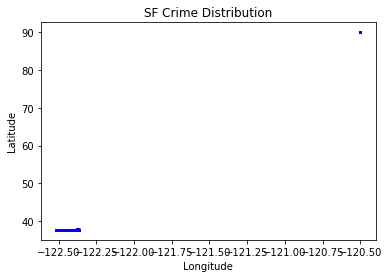

In [18]:
fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df.X, df.Y, s = 2, c = 'b')
plt.show()

As we could see, there is the outliers that impact the visualization.

In [59]:
df=df[df['X']!=df['X'].max()]
#df=df.drop(df.X.idxmax())

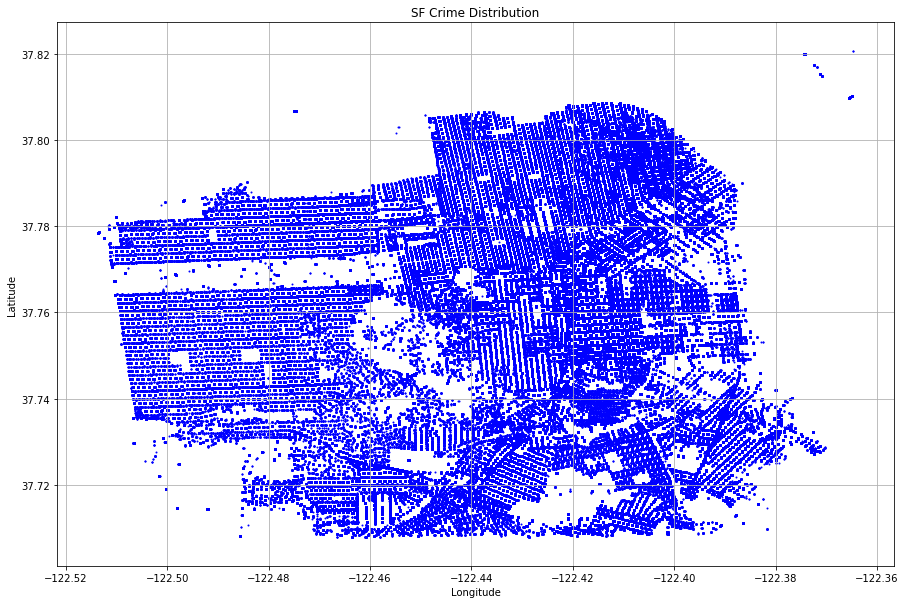

In [63]:
fig = plt.figure(figsize=(15,10))
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df.X, df.Y, s = 1, c = 'b')
plt.grid(True)
plt.show()